# Handle spatial data 

In [1]:
import geopandas as gpd #handle shape file 
import matplotlib.pyplot as plt #Make graph

import numpy as np #Mathematical functions
import pandas as pd #

from shapely import wkt
#import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 15,15

import warnings
warnings.filterwarnings('ignore')

## Part 1:  Handle spatial data of beneficiaries of non-contributory monetary transfers in Quito - MIES

In [2]:
#Database from MIES

# BDH and others pensions 
df_1 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 1 AGO2023",dtype={'dpa_prov': str})
df_2 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 2 AGO2023")
df_MIES = pd.concat([df_1, df_2], ignore_index=True)

df_ben = df_MIES.groupby(['dpa_desprov','beneficio'])['beneficio'].count().reset_index(name='Total_beneficiarios')
df_ben.head(3)


,dpa_desprov,beneficio,Total_beneficiarios
0,AZUAY,BONO 1000 DIAS,1731
1,AZUAY,BONO DE DESARROLLO HUMANO,25914
2,AZUAY,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,8903
3,AZUAY,BONO JOAQUIN GALLEGOS LARA,1280
4,AZUAY,PENSION MIS MEJORES AÑOS,14056
...,...,...,...
193,ZONA EN ESTUDIO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,427
194,ZONA EN ESTUDIO,PENSION MIS MEJORES AÑOS,423
195,ZONA EN ESTUDIO,PENSION PARA ADULTOS MAYORES,1
196,ZONA EN ESTUDIO,PENSION PARA PERSONAS CON DISCAPACIDAD,1


In [3]:
df_MIES_Quito = df_MIES[df_MIES['dpa_descan']=='DISTRITO METROPOLITANO DE QUITO']
df_MIES_Quito.head(3)

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,x,y,corte
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,-78.453238,-0.259818,ago 2023
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023
985,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,76.0,-78.561565,-0.334326,ago 2023
1119,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,75.0,-78.571653,-0.330162,ago 2023


<Axes: >

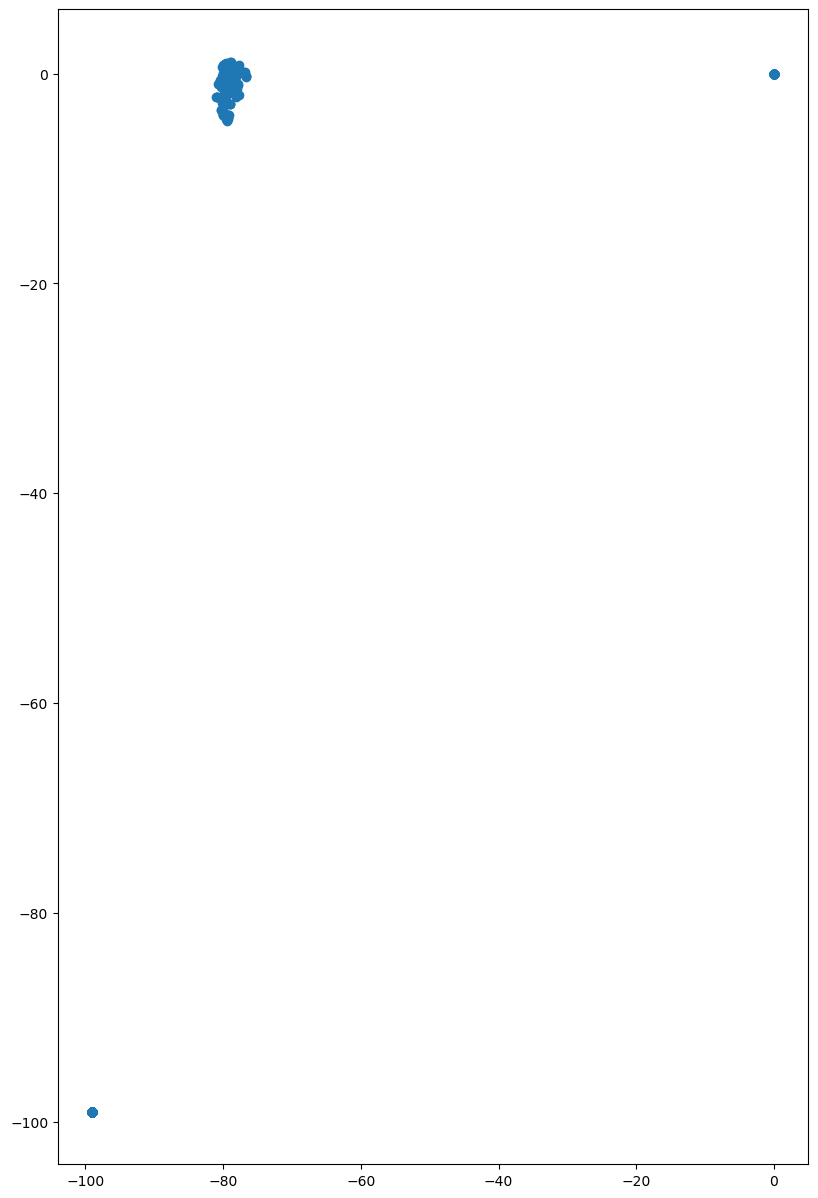

In [4]:
# Convert  MIES´s Database to spatial format "EPSG:4326"

df_MIES_Quito.dropna(subset=['x', 'y'], inplace= True)

df_MIES_gdf= gpd.GeoDataFrame(df_MIES_Quito, geometry= gpd.points_from_xy(df_MIES_Quito['x'],df_MIES_Quito['y']))
df_MIES_gdf['geometry'] = df_MIES_gdf['geometry'].astype(str).apply(wkt.loads)
gdf_hog = gpd.GeoDataFrame(df_MIES_gdf)

gdf_hog = gdf_hog.set_crs("EPSG:4326")
gdf_hog.plot()

MIES points have wrong geographical coor (points that are outside Quito), the following steps are performed:

1. The shapefile of Quito's Barrios is loaded and converted into the 4326 format (same geographic format as the MIES base)

In [5]:
df_barr= gpd.read_file("../data/Parroquia Quito/PARROQUIAS_REF.shp") #Se lee la base de datos .Shp
df_barr= df_barr.to_crs("EPSG:4326")

In [6]:
# Definir la lista de palabras
Urbanos = [
    "BELISARIO QUEVEDO",
    "COMITE DEL PUEBLO",
    "JIPIJAPA",
    "PONCEANO",
    "EL INCA",
    "CONCEPCION",
    "KENNEDY",
    "PUENGASI",
    "CARCELEN",
    "COTOCOLLAO",
    "LA ARGELIA",
    "QUITUMBE",
    "CENTRO HISTORICO",
    "EL CONDADO",
    "LA ECUATORIANA",
    "RUMIPAMBA",
    "CHILIBULO",
    "MAGDALENA",
    "LA FERROVIARIA",
    "SAN BARTOLO",
    "CHILLOGALLO",
    "GUAMANI",
    "LA LIBERTAD",
    "SAN JUAN",
    "CHIMBACALLE",
    "IÑAQUITO",
    "LA MENA",
    "SOLANDA",
    "COCHAPAMBA",
    "ITCHIMBIA",
    "MARISCAL SUCRE",
    "TURUBAMBA"
]




In [7]:

def es_urbano(barrio):

    # Función para verificar si alguna de las palabras de la lista está presente en la columna 'barrios'

    for palabra in Urbanos:
        if palabra in barrio:
            return 'Urbano' 
    return 'No Urbano'

df_barr['Urbana'] = df_barr['dpa_despar'].apply(lambda x: es_urbano(x))
df_barr= df_barr[df_barr['Urbana']=='Urbano']



2. Interception between beneficiaries of non-contributory monetary transfers and Quito's Barrios shapefile.

In [8]:
df_final = gpd.sjoin(gdf_hog,df_barr,how='left')
df_final.head(3)

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar_left,beneficio,edad,x,y,corte,geometry,index_right,id,dpa_parroq,dpa_despar_right,Urbana
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,-78.453238,-0.259818,ago 2023,POINT (-78.45324 -0.25982),NaN,NaN,NaN,NaN,NaN
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023,POINT (-78.46789 -0.12637),51.0,51.0,170105,COMITE DEL PUEBLO,Urbano
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023,POINT (-78.56142 -0.32485),48.0,48.0,170111,GUAMANI,Urbano


3. The points that are outside of Quito are eliminated

<Axes: >

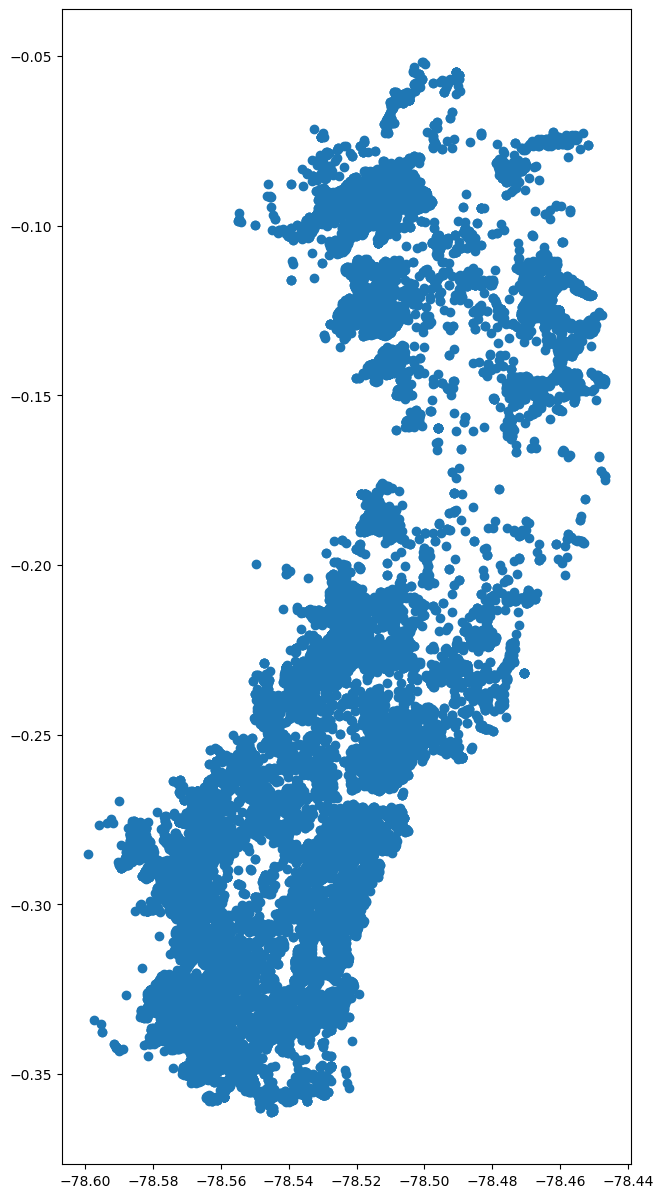

In [9]:
df_final.dropna(subset=['dpa_parroq'], inplace = True )
df_final.plot()

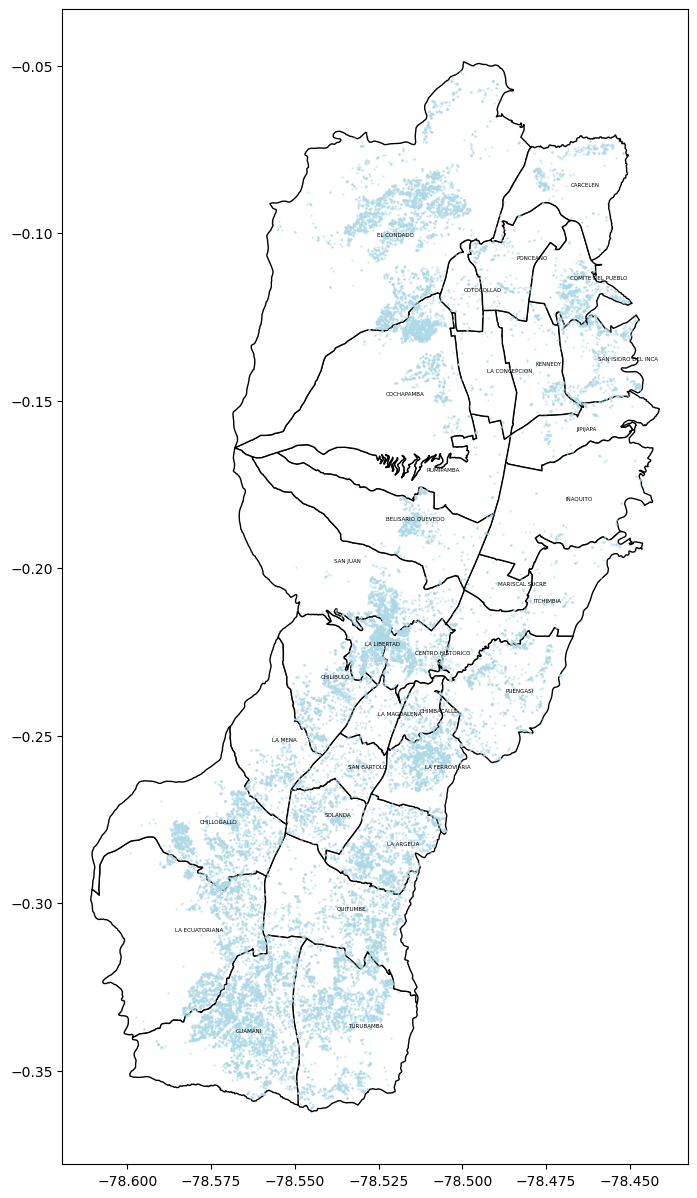

In [10]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Graficar los polígonos del DataFrame df_barr. 
df_barr.plot(ax=ax, color='white', edgecolor='black')

# Graficar los puntos del DataFrame df_final.
df_final.plot(ax=ax, marker='o', color='lightblue', markersize=0.5, alpha=0.5)

# Agregar etiquetas a las zonas de df_barr
for x, y, label in zip(df_barr.geometry.centroid.x, df_barr.geometry.centroid.y, df_barr['dpa_despar']):
    ax.annotate(label, (x, y), fontsize=4)

plt.show()

In [11]:
df_final_nben = df_final.groupby([ 'dpa_parroq', 'dpa_despar_right']).size().reset_index(name='n_beneficiarios')
df_barr2= df_barr.merge(df_final_nben, how= 'left', on= ['dpa_parroq']).drop(['dpa_despar_right'], axis=1)
df_barr2.head()

,id,dpa_parroq,dpa_despar,geometry,Urbana,n_beneficiarios
0,1,170132,TURUBAMBA,"POLYGON ((-78.53054 -0.31947, -78.53038 -0.319...",Urbano,2421
1,2,170118,LA ECUATORIANA,"POLYGON ((-78.58793 -0.28531, -78.58725 -0.285...",Urbano,1875
2,3,170126,QUITUMBE,"POLYGON ((-78.54441 -0.28241, -78.54406 -0.282...",Urbano,1461
3,4,170108,CHILLOGALLO,"POLYGON ((-78.56410 -0.26369, -78.56436 -0.264...",Urbano,2043
4,5,170122,LA MENA,"POLYGON ((-78.55239 -0.23436, -78.55211 -0.235...",Urbano,446


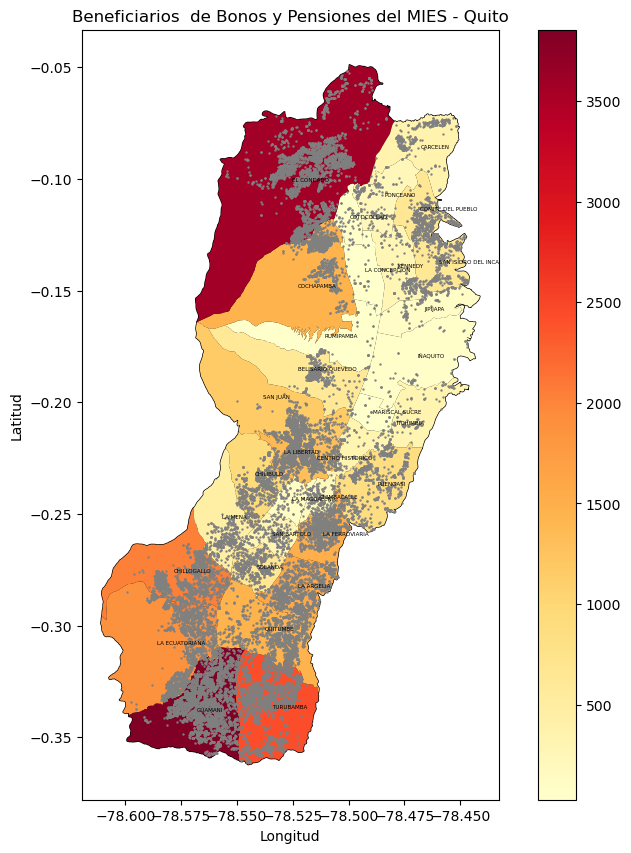

In [12]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')


df_barr.plot(ax=ax, color='white', edgecolor='black')
df_barr2.plot(ax=ax, column='n_beneficiarios', cmap='YlOrRd', legend=True, alpha=1)

# Agregar etiquetas a las zonas de df_barr
for x, y, label in zip(df_barr.geometry.centroid.x, df_barr.geometry.centroid.y, df_barr['dpa_despar']):
    ax.annotate(label, (x, y), fontsize=4)

# Graficar los puntos del DataFrame df_final
df_final.plot(ax=ax, marker='o', color='gray', markersize=0.5, alpha=1)

# Título y etiquetas
plt.title('Beneficiarios  de Bonos y Pensiones del MIES - Quito')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()


In [13]:
#Save df_final for the next parts. 

df_final.drop(['zon_plan','uni_des_mi','dpa_prov','dpa_desprov','dpa_can','dpa_descan','dpa_despar_left','dpa_par','dpa_despar_left','index_right','id'], axis=1).to_file('../data/MIES points/MIES_points.shp') 
df_barr.to_file('../data/Quito Urbano/Quito_Urbano.shp') 